In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [59]:
flex_path = 'flexSensors4.npy'
pressure_path = 'pressureSensors2.npy'
accelerometers_path = 'accelerometers.npy'
flex_null_path = 'flexSensors_baseline.npy'
flex_full_path = 'flexSensors_full_bend.npy'

acclData = np.load(accelerometers_path)
flexData = np.load(flex_path)
flexNull = np.load(flex_null_path)
flexFull = np.load(flex_full_path)
presData = np.load(pressure_path)

Text(0.5, 1.0, 'Flex Data')

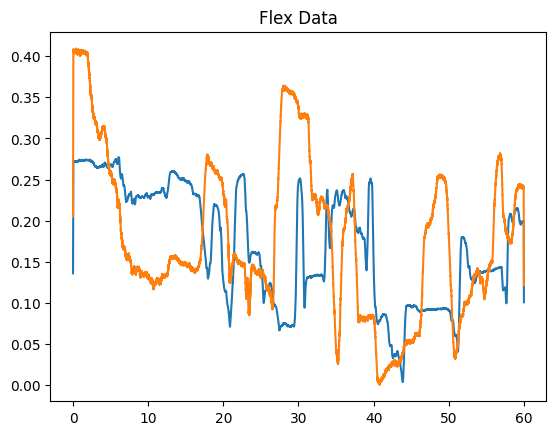

In [60]:
# peg minimum value of flex data to 0, could smooth the data firsts to avoid the manual shift
normalized_0 = np.subtract(flexData[:,1], np.min(flexData[:,1]))
normalized_1 = np.subtract(flexData[:,2], np.min(flexData[:,2]))
normalized_1 = np.subtract(normalized_1, 0.05) # manual shift, ideally wouldn't have to do this but theres some weird minimum value messing up our shift

def convolve_smooth(
    arr : np.ndarray, 
    window_size : int = 128,
    )-> np.ndarray:

    kernel = np.ones(window_size) / window_size
    res = np.convolve(arr, kernel, mode='same')
    return res

# smooth data after peg minimum value to 0
smoothe_0 = convolve_smooth(normalized_0)
smoothe_1 = convolve_smooth(normalized_1)

# plot
plt.plot(flexData[:,0], smoothe_0)
plt.plot(flexData[:,0], smoothe_1)
plt.title("Flex Data")

## Simple Framework for Analyzing Efficiency of a Discrete Move
Generally, climbing moves become more efficient as more weight is placed on the feet (reducing the load on the upper body) and as the arms become straighter (transfering load from soft tissue including muscle and tendons to the skeleton). If we can quantify the area under the curve for elbow flex and pressure on the feet we can come up with a unitless number to represent the "efficiency" of a move on a scale from 0 to 1. Where 0 would represent arms fully bent with no weight on the feet and 1 represents the entire body weight on the feet and straight arms. This is a gross oversimplification as it ignores many factors including but not limited to shoulder engagement, body position, knee flexion, and many many others. Perhaps most importantly we are capturing arm bend even when the limb is not contancting the wall this gives us information that we don't care about. Arm bend does not matter if no contact is occuring. This could be resolved via finger pressure sensors. Even with these shortcomings, we have a potentially viable framework for analyzing *very basic* climbing moves.

### Important TimeSteps in Video
- Establish (all points on wall) : $t=13s$
- First left hand move end : $t=14s$
- First right foot move end : $t=17s$
- First right hand move end : $t=18s$
- Second left hand move end : $t=20s$
- sequence of foot moves (right foot up, match left foot, right foot up) end : $t=23s$
- left hand move, right hand match on finish end : $t=27s$

We can look at slices between these moves to calculate our "efficiency". The most interesting moves for this type of analysis are given in the last 2 bullet points above.

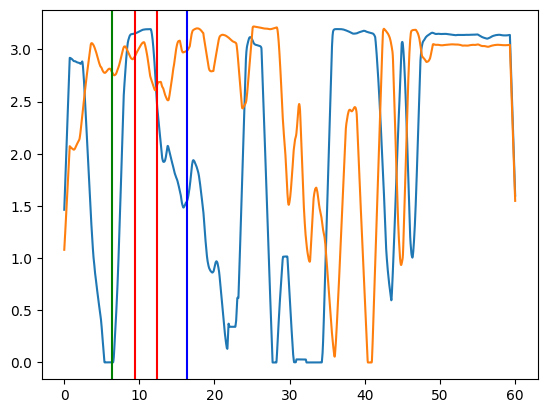

In [61]:
plt.plot(acclData[:,0], convolve_smooth(presData[:,1]))
plt.plot(acclData[:,0], convolve_smooth(presData[:,2]))
plt.axvline(6.4, color='g') # t = 17s
plt.axvline(9.4, color='r') # t = 20s (start of sequence of foot moves)
plt.axvline(12.4, color='r') # t = 23s (end of sequence of foot moves), start of finish match
plt.axvline(16.4, color='b') # t = 27s (end of sequence of foot moves), start of finish match
plt.title('Pressure Data')

### Breakdown:
In the plot above the data between the red bars represent a sqeuence of fast foot moves that take place from 20 - 23 seconds in the video. And the data between the 2nd red bar and the blue bar represent the finish match which takes place from 23-27 seconds in the video (finishing the boulder.) We are not really interested in any of the data after this time because it is not representative of normal climbing, rather Tobin down climbed to avoid breaking the sensors instead of jumping down as normal.

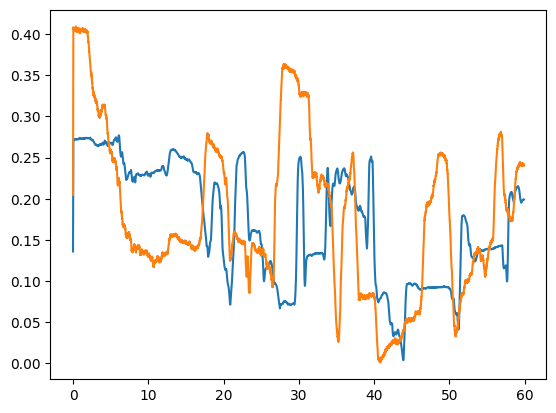

In [67]:
smooth_flex_0 = convolve_smooth(flexData[:,1])
smooth_flex_1 = convolve_smooth(flexData[:,2])

# downsample and clip
sub_time = flexData[:,0][::20][:acclData.shape[0]:]
# downsample
sub_smooth_flex_0 = smoothe_0[::20]
sub_smooth_flex_1 = smoothe_1[::20]

# clip
sub_smooth_flex_0 = sub_smooth_flex_0[:acclData.shape[0]:]
sub_smooth_flex_1 = sub_smooth_flex_1[:acclData.shape[0]:]

#updating flex data array
flexData = np.column_stack((sub_time, sub_smooth_flex_0, sub_smooth_flex_1))

plt.plot(sub_time, sub_smooth_flex_0)
plt.plot(sub_time, sub_smooth_flex_1)

In [68]:
# returns index of closest value in array
# https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/
def find_nearest(array, value):
    difference_array = np.absolute(array - value)
    index = difference_array.argmin()
    return index

def efficiency(
    start_time, 
    end_time, 
    flex, 
    pressure
    ):
    
    period = end_time - start_time

    # calculate index bounds
    flex_start = find_nearest(flex[:,0], start_time)
    flex_end = find_nearest(flex[:,0], end_time)
    pressure_start = find_nearest(pressure[:,0], start_time)
    pressure_end = find_nearest(pressure[:,0], end_time)

    # calculate areas under the curve
    flex_area_1 = np.trapz(flex[flex_start:flex_end, 1], x=flex[flex_start:flex_end, 0])
    flex_area_2 = np.trapz(flex[flex_start:flex_end, 2], x=flex[flex_start:flex_end, 0])
    pressure_area_1 = np.trapz(pressure[pressure_start:pressure_end, 1], x=pressure[pressure_start:pressure_end, 0])
    pressure_area_2 = np.trapz(pressure[pressure_start:pressure_end, 2], x=pressure[pressure_start:pressure_end, 0])

    # calculate averages
    flex_area = (flex_area_1 + flex_area_2) / 2
    pressure_area = (pressure_area_1 + pressure_area_2) / 2

    # calculate efficiency
    # Weights: 30% flex, 70% pressure
    flex_weight, pressure_weight = 0.3, 0.7

    # calculate weighted areas
    flex_area_weighted = flex_weight * flex_area
    pressure_area_weighted = pressure_weight * pressure_area

    # calculate combined area
    combined_area = flex_area_weighted + pressure_area_weighted

    # normalize area
    # find maximum value in the data from both arrays
    data_max = max(np.max(flex[:,1:]), np.max(pressure[:,1:]))

    normal_efficiency = (combined_area / data_max) / period

    # area under the curve for each
    return normal_efficiency 

In [69]:
foot_moves_efficiency = efficiency(
    start_time=9.4,
    end_time=12.4,
    flex=flexData,
    pressure=presData
)

finish_move_efficiency = efficiency(
    start_time=12.4,
    end_time=16.4,
    flex=flexData,
    pressure=presData
)

print(f"foot sequence : {foot_moves_efficiency}")
print(f"finish sequence : {finish_move_efficiency}")

foot sequence : 0.6669520017366263
finish sequence : 0.5123785647099138


## Conclusion

Here we can see that the foot moves are "more efficient".  

The accuracy of this is questionable because of following errors during the measurement process. The pressure sensors we used were intended for much lighter weights (at around 10 lbs instead of my entire bodyweight). The duct tape holding the pressure sensors onto my feet was flimsy and the pressure sensors were not in the exact same places. Additionally, the flex sensors were held onto the inside of my elbows using duct tape. While this was workable and much better reliability wise than having the flex sensors on the outside of the elbow. However, this did not eliminate all of the issues. Because we used tape to hold the flex sensors on, the tape loosed as time went on and I climbed. This resulted in the flex sensor bending inconsistently based on elbow flexion due to the tape becoming loose and the flex sensor pushing into it rather than bending. With a more appropriate and flexible flex sensor, this could be come more reliable

## Jerk Analysis

Jerk is the derivative of acceleration (change in acceleration with respect to time). This could add another tool to our ability to determine movement efficiency. Less jerk means more efficient movement because the body has to put in less effort to adjust to changes in acceleration or jerk. Jerk can be conceptualized as smoothness of movement. https://www.frontiersin.org/articles/10.3389/fbioe.2021.782740/full. Because of this jerk is also associated with risk of injury. Less smooth or rougher movements will lead to a higher risk of injury. See the magnitude of the jerk in the left and right hands in the graph below. This would be useful as a comparison tool between different moves, sequences of moves, or different climbers. See the trivial example below

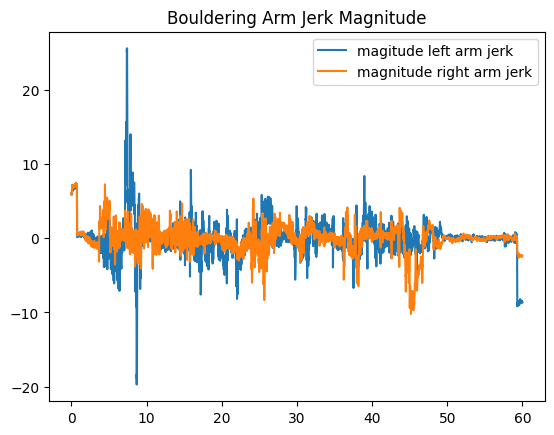

In [88]:
# accelerometer 0 was com, accelerometer left was 1, accelerometer was 2
# time will be 0
# COM accel 0 will be 1, 2, 3
# LARM accel 1 will be 4, 5, 6
# RARM accel 2 will be 7, 8, 9

# calculate magnitude of acceleration for each arm
acc_left_arm_mag = np.sqrt(np.sum(np.power(acclData[:,4:7], 2), axis=1))
acc_right_arm_mag = np.sqrt(np.sum(np.power(acclData[:,7:10], 2), axis=1))

# calculate first derivative of magnitude of acceleration (giving us magnitude of jerk)
left_jerk = np.gradient(convolve_smooth(acc_left_arm_mag), acclData[:,0], edge_order=2 )
right_jerk = np.gradient(convolve_smooth(acc_right_arm_mag), acclData[:,0], edge_order=2 )

# plot
plt.plot(acclData[:,0], left_jerk, label='magitude left arm jerk')
plt.plot(acclData[:,0], right_jerk, label='magnitude right arm jerk')
plt.title('Bouldering Arm Jerk Magnitude')
plt.legend()